### TCGA to CCLE mutation prediction: LASSO parameter range experiments

Here, we're interested in training mutation status models on data from TCGA (human tumor samples) and testing on data from CCLE (cancer cell lines). This is similar to our other experiments where we hold out and evaluate on all data from a single cancer type, but now the "domains" are entire datasets rather than cancer types from the same dataset.

This script plots the detailed results of varying regularization strength (LASSO parameter) for a single gene.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
results_dir = os.path.join(
    cfg.repo_root, '08_cell_line_prediction', 'results', 'tcga_to_ccle'
)

plot_gene = 'RB1'
metric = 'aupr'

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range(results_dir, gene=plot_gene):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
nz_coefs_df.drop(columns=['cancer_type'], inplace=True)
nz_coefs_df.lasso_param = nz_coefs_df.lasso_param.astype(float)
nz_coefs_df = nz_coefs_df[nz_coefs_df.gene == plot_gene].copy()
nz_coefs_df.head()

,gene,lasso_param,seed,fold,nz_coefs
0,RB1,10.00,42,0,4558
1,RB1,10.00,42,1,4246
2,RB1,10.00,42,2,4266
3,RB1,10.00,42,3,2716
4,RB1,0.05,1,0,409


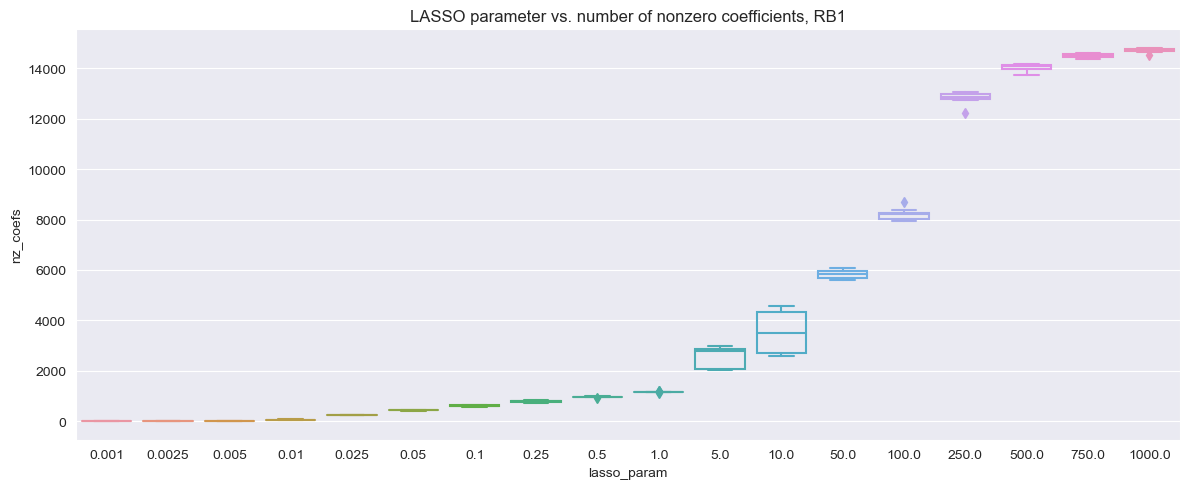

In [4]:
sns.set({'figure.figsize': (12, 5)})

sns.boxplot(
    data=nz_coefs_df.sort_values(by=['lasso_param']),
    x='lasso_param', y='nz_coefs'
)

# color the boxplot lines/edges rather than the box fill
# this makes it easier to discern colors at the extremes; i.e. very many or few nonzero coefs
# https://stackoverflow.com/a/72333641
ax = plt.gca()
box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):
    # set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')

    # each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers

plt.title(f'LASSO parameter vs. number of nonzero coefficients, {plot_gene}')
plt.tight_layout()

### Get performance information for each lasso penalty

In [5]:
perf_df = au.load_prediction_results_lasso_range(results_dir,
                                                 'tcga_to_ccle',
                                                 gene=plot_gene)

perf_df.drop(columns=['holdout_cancer_type'], inplace=True)
perf_df.lasso_param = perf_df.lasso_param.astype(float)
perf_df = perf_df[perf_df.gene == plot_gene].copy()
perf_df.head()

,auroc,aupr,gene,signal,seed,data_type,fold,experiment,lasso_param
0,0.5,0.10074,RB1,signal,1,train,0,tcga_to_ccle,0.001
1,0.5,0.22505,RB1,signal,1,test,0,tcga_to_ccle,0.001
2,0.5,0.11560,RB1,signal,1,cv,0,tcga_to_ccle,0.001
3,0.5,0.10394,RB1,signal,1,train,1,tcga_to_ccle,0.001
4,0.5,0.22505,RB1,signal,1,test,1,tcga_to_ccle,0.001


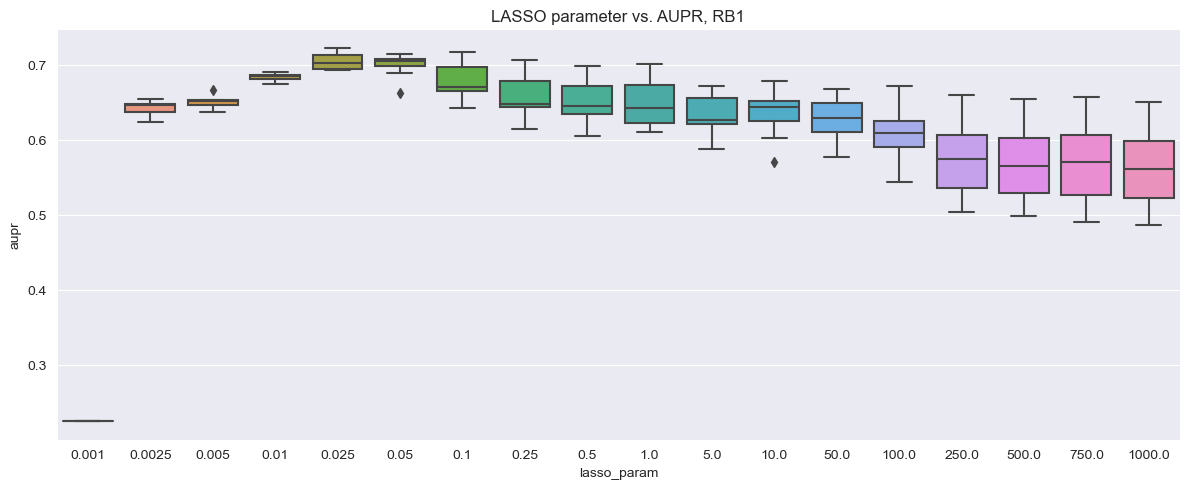

In [6]:
sns.set({'figure.figsize': (12, 5)})

sns.boxplot(
    data=(
        perf_df[(perf_df.signal == 'signal') &
                (perf_df.data_type == 'test')]
          .sort_values(by=['lasso_param'])
    ), x='lasso_param', y=metric
)
plt.title(f'LASSO parameter vs. {metric.upper()}, {plot_gene}')
plt.tight_layout()

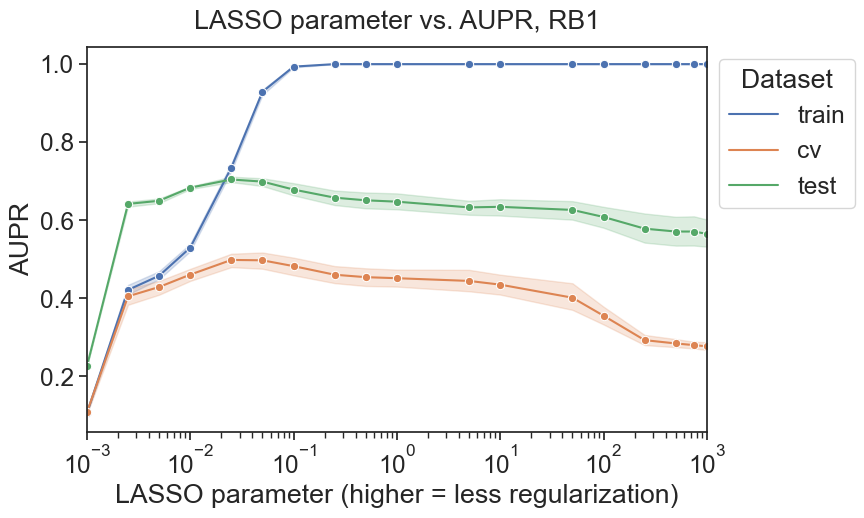

In [7]:
# plot LASSO parameter vs. AUPR, for all 3 datasets
# "train" = data used to train model
# "cv" = validation set from TCGA (not used to train model)
# "test" = CCLE data (not used to train model)
sns.set({'figure.figsize': (8, 5)})
sns.set_style('ticks')

plot_df = (
    perf_df[(perf_df.signal == 'signal')]
      .sort_values(by=['lasso_param'])
      .reset_index(drop=True)
)
plot_df.lasso_param = plot_df.lasso_param.astype(float)

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.lineplot(
        data=plot_df,
        x='lasso_param', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o'
    )
    g.set(xscale='log', xlim=(min(plot_df.lasso_param), max(plot_df.lasso_param)))
    g.set_title('Holdout cancer type: {col_name}')
    g.set_xlabel('LASSO parameter (higher = less regularization)')
    g.set_ylabel(f'{metric.upper()}')
    
    ax = plt.gca()
    legend_handles, legend_labels = ax.get_legend_handles_labels()
    ax.legend(legend_handles, legend_labels, title='Dataset')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    
    plt.title(f'LASSO parameter vs. {metric.upper()}, {plot_gene}', y=1.025)

### Visualize "best" LASSO parameters for the given gene

We want to use two different strategies to pick the "best" LASSO parameter:

1. Choose the top 25% of LASSO parameters based on validation set AUPR, then take the smallest model (least nonzero coefficients) in that set. This is the "parsimonious" approach that assumes that smaller models will generalize better.
2. Choose the top LASSO parameter based solely on validation set AUPR, without considering model size. This is the "non-parsimonious" approach.

We'll plot the results of both strategies (which sometimes select the same parameter, but usually they're different) for the given gene below.

In [8]:
def get_top_and_smallest_lasso_params(perf_df):
    top_df = (
        perf_df[(perf_df.data_type == 'cv') &
                (perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
          .sort_values(by='mean_aupr', ascending=False)
    )
    top_df.index = top_df.index.astype(float)
    top_df['aupr_rank'] = top_df.mean_aupr.rank(ascending=False)
    top_5_lasso = top_df.loc[top_df.aupr_rank <= 5, :].index
    
    # get parameter with best validation performance
    top_lasso_param = top_5_lasso[0]

    # get parameter in top 5 validation performance with least nonzero coefficients
    smallest_lasso_param = (
        nz_coefs_df[(nz_coefs_df.lasso_param.isin(top_5_lasso))]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .sort_values(by='nz_coefs', ascending=True)
    ).index[0]
    
    compare_df = top_df.loc[
        [smallest_lasso_param, top_lasso_param], :
    ]
    compare_df['desc'] = ['smallest', 'best']
    return compare_df

In [9]:
compare_df = get_top_and_smallest_lasso_params(perf_df)
compare_df

,mean_auroc,mean_aupr,aupr_rank,desc
lasso_param,,,,
0.010,0.860707,0.460365,4.0,smallest
0.025,0.877236,0.498045,1.0,best


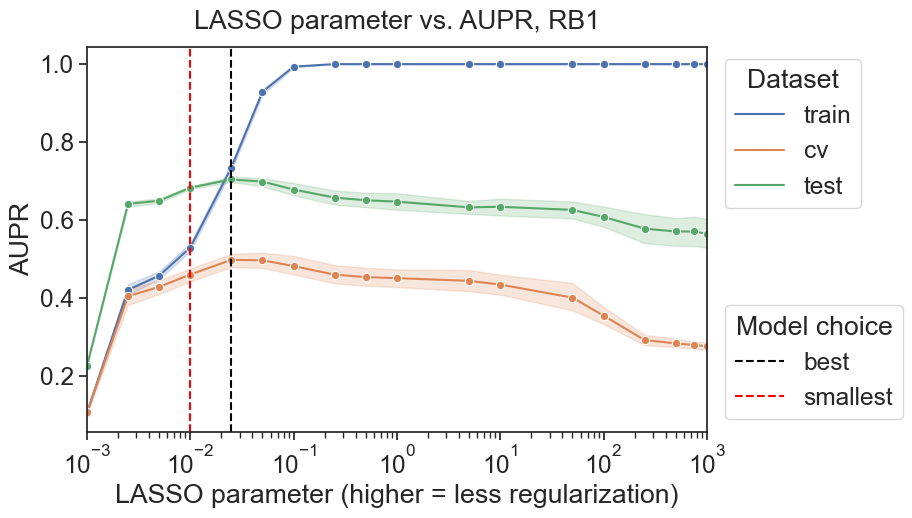

In [10]:
# same plot as before but with the "best"/"smallest" parameters marked
sns.set({'figure.figsize': (8, 5)})
sns.set_style('ticks')

plot_df = (
    perf_df[(perf_df.signal == 'signal')]
      .sort_values(by=['lasso_param'])
      .reset_index(drop=True)
)
plot_df.lasso_param = plot_df.lasso_param.astype(float)

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.lineplot(
        data=plot_df,
        x='lasso_param', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o'
    )
    g.set(xscale='log', xlim=(min(plot_df.lasso_param), max(plot_df.lasso_param)))
    g.set_xlabel('LASSO parameter (higher = less regularization)')
    g.set_ylabel(f'{metric.upper()}')
    
    ax = plt.gca()
    ax.axvline(x=compare_df[(compare_df.desc == 'best')].index.values[0],
               color='black', linestyle='--')
    ax.axvline(x=compare_df[(compare_df.desc == 'smallest')].index.values[0],
               color='red', linestyle='--')
        
    # create custom legend for best models lines
    legend_handles = [
        Line2D([0], [0], label='asdf', color='black', linestyle='--'),
        Line2D([0], [0], label='fdsa', color='red', linestyle='--'),
    ]
    legend_labels = ['best', 'smallest']
    l = ax.legend(legend_handles, legend_labels, title='Model choice',
                  loc='lower left', bbox_to_anchor=(1.01, 0))
    ax.add_artist(l)
    
    legend_handles, legend_labels = ax.get_legend_handles_labels()
    ax.legend(legend_handles, legend_labels, title='Dataset')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1.01, 1))
    plt.title(f'LASSO parameter vs. {metric.upper()}, {plot_gene}', y=1.025)